# Exploratory Data Analysis

## Classes Count 

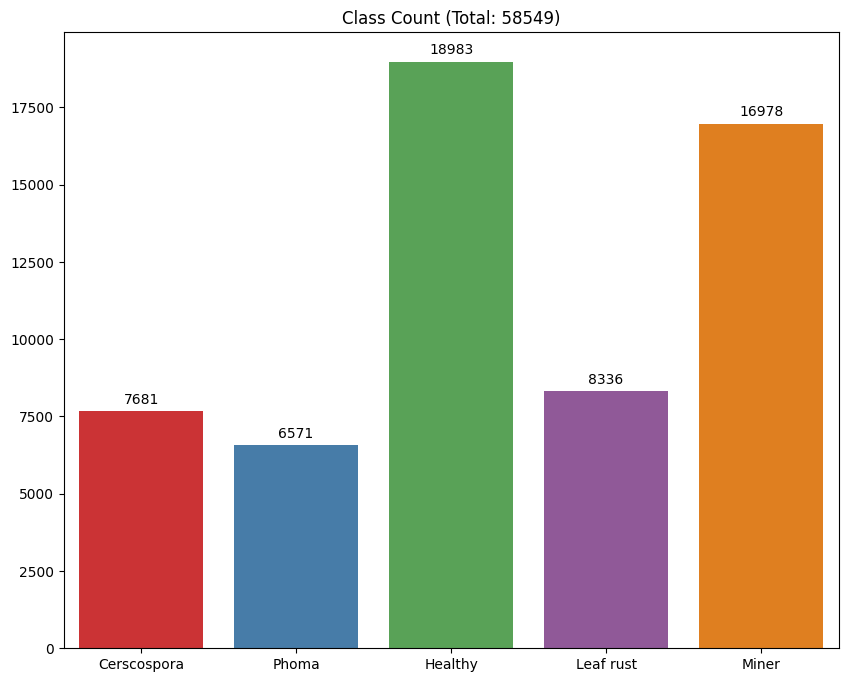

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

dataset_path = 'data'

class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in os.listdir(dataset_path)}

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=class_counts.keys(), y=class_counts.values(), hue=class_counts.keys(), palette='Set1')

for i in ax.containers:
    ax.bar_label(i, fmt='%d', padding=3)

plt.title(f'Class Count (Total: {sum(class_counts.values())})')
plt.show()


The dataset has more samples of Healthy and Miner classes.

In [2]:
import shutil
from hashlib import md5

hashes = []
duplicates = 0

new_path = 'dataset'
os.mkdir(new_path)

for cls in os.listdir(dataset_path):
    os.mkdir(os.path.join(new_path, cls))

    for filename in os.listdir(os.path.join(dataset_path, cls)):
        filepath = os.path.join(dataset_path, cls, filename)

        with open(filepath, 'rb') as f:
            data = f.read()

        hash = md5(data).hexdigest()

        if hash not in hashes:
            shutil.copyfile(filepath, os.path.join(new_path, cls, filename))
            hashes.append(hash)
        else:
            duplicates += 1

print(f'Found {duplicates} duplicates')
print(f'Copied {len(hashes)} to {new_path!r}')

Found 54793 duplicates
Copied 3756 to 'dataset'


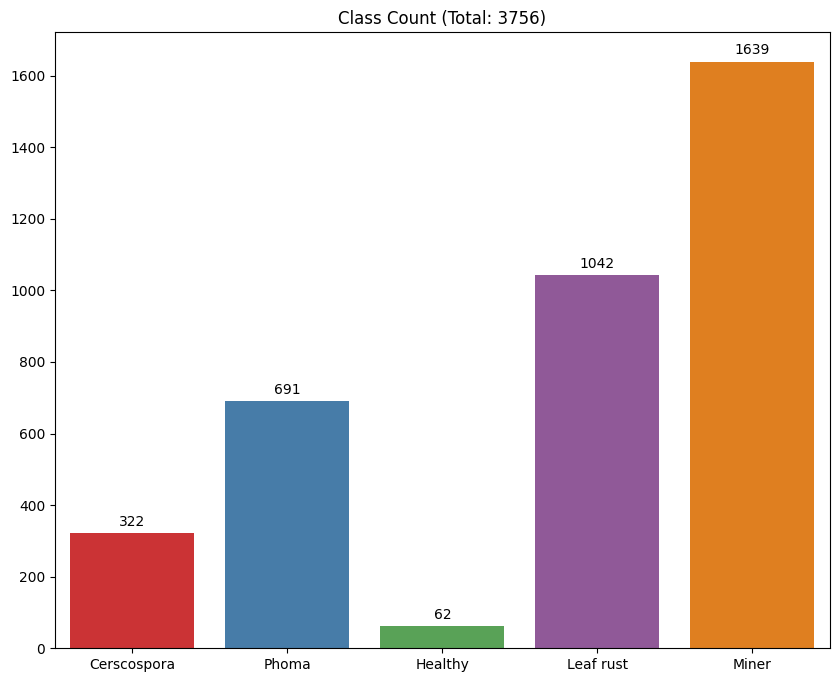

In [3]:
dataset_path = new_path

class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in os.listdir(dataset_path)}

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=class_counts.keys(), y=class_counts.values(), hue=class_counts.keys(), palette='Set1')

for i in ax.containers:
    ax.bar_label(i, fmt='%d', padding=3)

plt.title(f'Class Count (Total: {sum(class_counts.values())})')
plt.show()


## Image Dimensions

In [4]:
import pandas as pd
from PIL import Image

image_sizes = []

for cls in os.listdir(dataset_path):
    for img_name in os.listdir(os.path.join(dataset_path, cls)):
        img = Image.open(os.path.join(dataset_path, cls, img_name))
        image_sizes.append({'Width': img.size[0], 'Height': img.size[1]})

df = pd.DataFrame(image_sizes)
df.describe()

,Width,Height
count,3756.000000,3756.000000
mean,129.521299,132.506922
std,17.824916,24.545145
min,74.000000,87.000000
25%,128.000000,128.000000
50%,128.000000,128.000000
75%,128.000000,128.000000
max,256.000000,256.000000


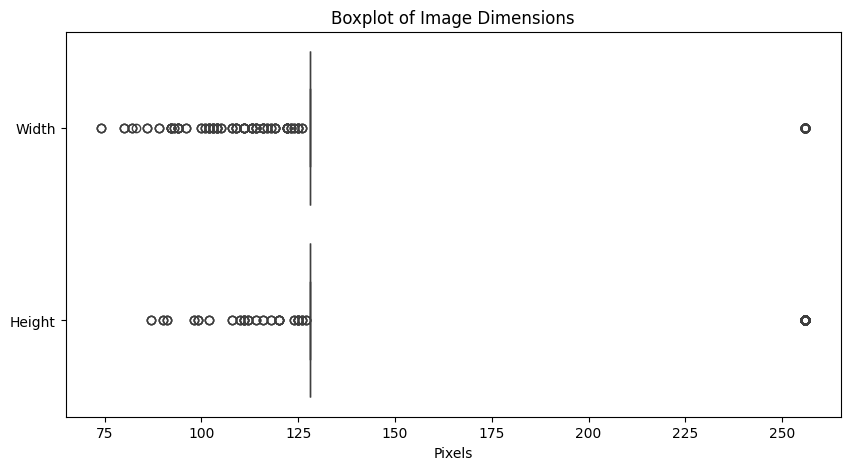

In [5]:
plt.figure(figsize=(10, 5))
sns.boxplot(df, whis=(5, 95), orient='h')
plt.title('Boxplot of Image Dimensions')
plt.xlabel('Pixels')
plt.show()

Most of the images are 128px in width and height. Making it ideal input size.

## Samples Visual Inspection

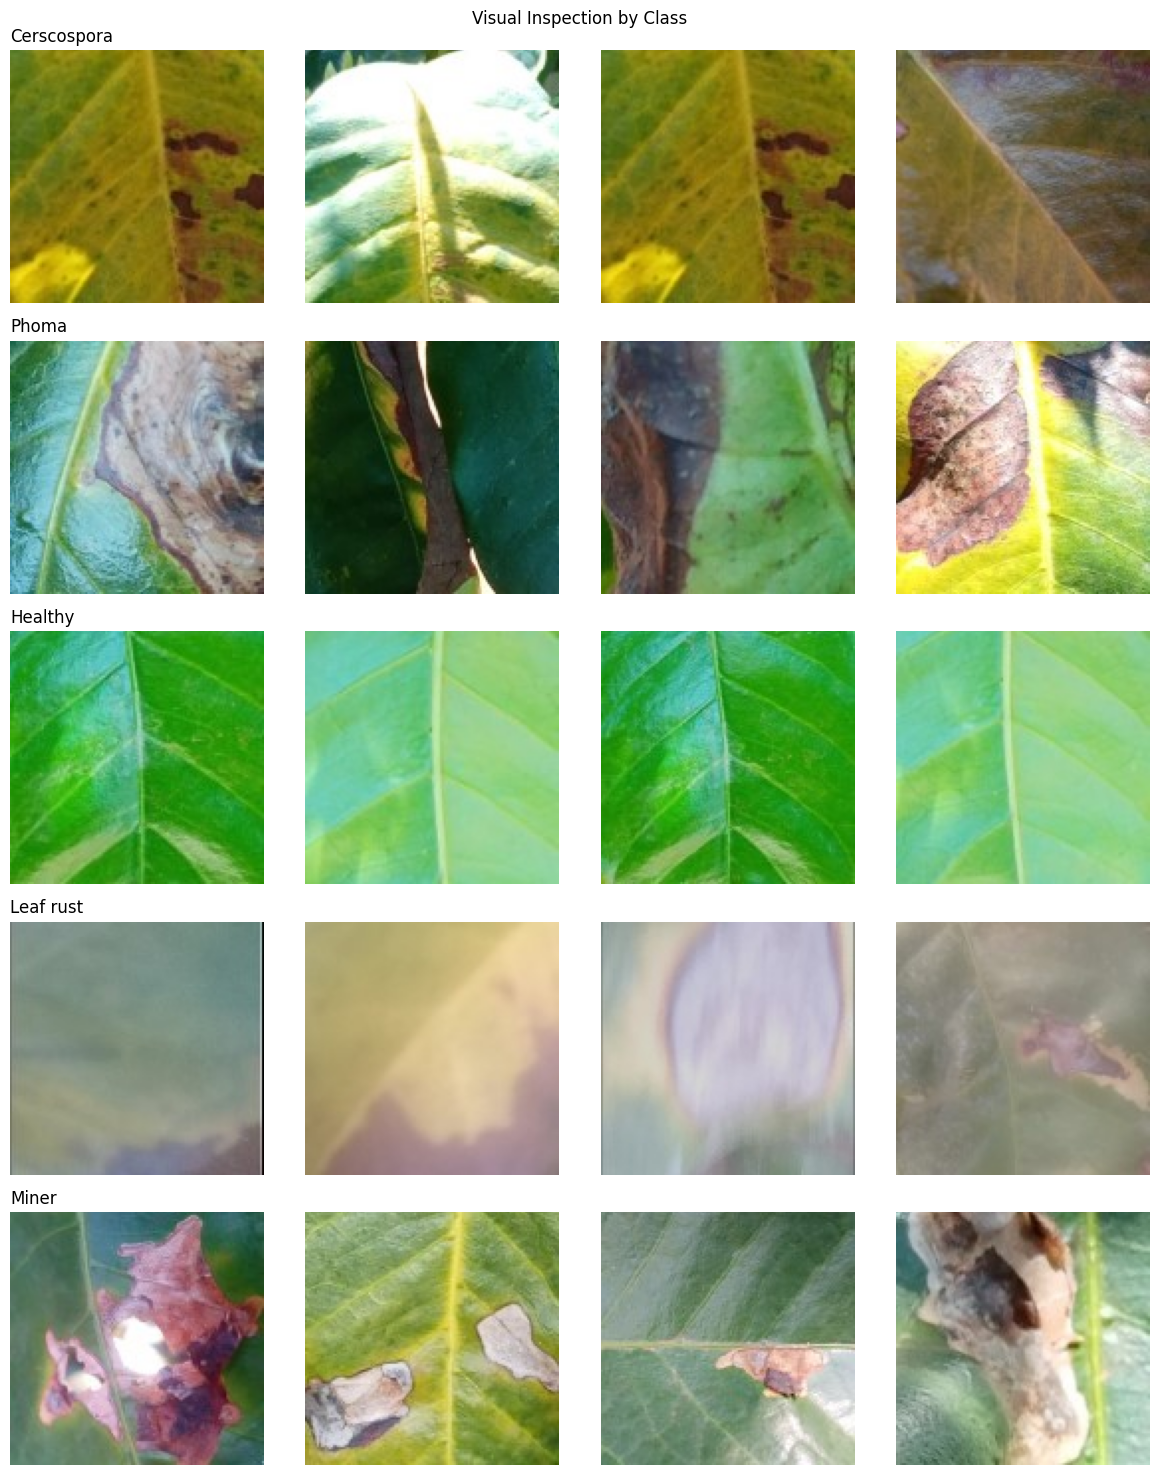

In [6]:
import random

random.seed(42)

classes = os.listdir(dataset_path)
num_samples_per_class = 4 
fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(12, 15))

for row, cls in enumerate(classes):
    cls_path = os.path.join(dataset_path, cls)
    sample_images = random.sample(os.listdir(cls_path), num_samples_per_class)

    for col, img_name in enumerate(sample_images):
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path)
        ax = axes[row, col] if len(classes) > 1 else axes[col] 
        ax.imshow(img)
        ax.axis('off')

        if col == 0: 
            ax.set_title(cls, loc='left')

plt.suptitle('Visual Inspection by Class')
plt.tight_layout()
plt.show()

## Dataset Splitting

The following will be the splits
| Dataset | Percentage |
| --- | --- |
| Train | 80 |
| Test | 20 |


In [7]:
import splitfolders

split_dataset_path = 'dataset_splitted'

splitfolders.ratio(dataset_path, output=split_dataset_path, seed=42, ratio=(.8, .2))

Copying files: 3756 files [00:01, 2870.59 files/s]


In [8]:
os.rename(os.path.join(split_dataset_path, 'val'), os.path.join(split_dataset_path, 'test'))

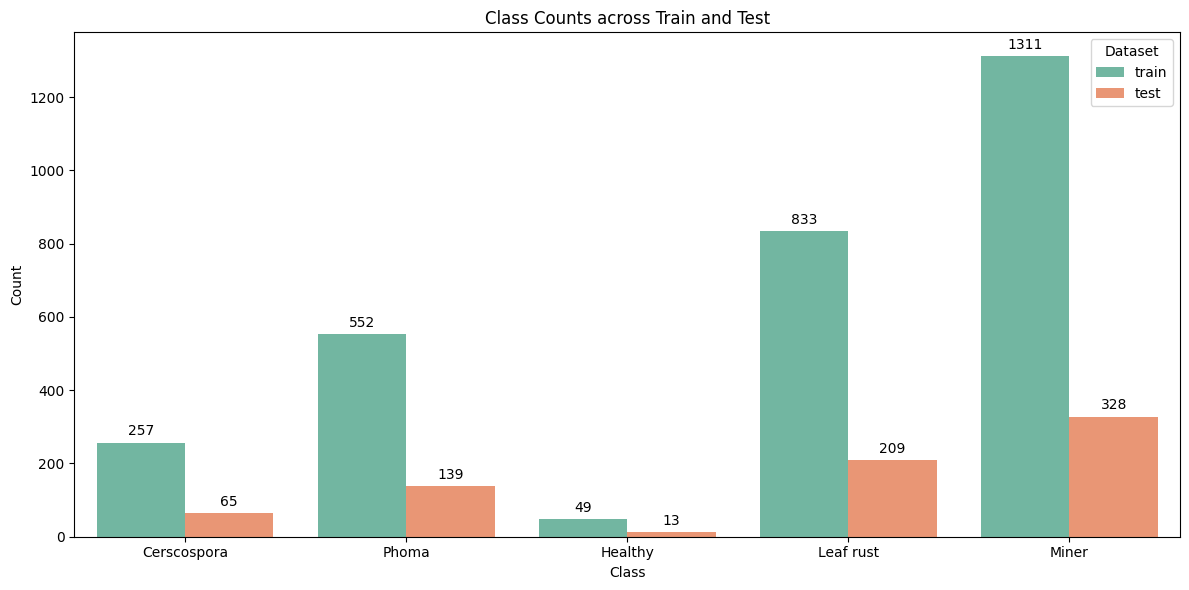

In [9]:
dataset_path = split_dataset_path

# Collect class counts for each dataset split
data = []

for split in ['train', 'test']:
    split_path = os.path.join(dataset_path, split)
    for cls in os.listdir(split_path):
        count = len(os.listdir(os.path.join(split_path, cls)))
        data.append({'Dataset': split, 'Class': cls, 'Count': count})

# Convert to a DataFrame for easier plotting
df = pd.DataFrame(data)

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='Class', y='Count', hue='Dataset', palette='Set2')
ax.set_title('Class Counts across Train and Test')
plt.xlabel('Class')
plt.ylabel('Count')

# Annotate counts on the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

## Data Augmentation

In [10]:
df

,Dataset,Class,Count
0,train,Cerscospora,257
1,train,Phoma,552
2,train,Healthy,49
3,train,Leaf rust,833
4,train,Miner,1311
5,test,Cerscospora,65
6,test,Phoma,139
7,test,Healthy,13
8,test,Leaf rust,209
9,test,Miner,328


Augment to have at least 500 train samples for each class 

In [11]:
df_ = df[df['Dataset']=='train']
df_.set_index(keys=['Class'], inplace=True, drop=True)
df_

,Dataset,Count
Class,,
Cerscospora,train,257
Phoma,train,552
Healthy,train,49
Leaf rust,train,833
Miner,train,1311


In [12]:
import Augmentor
import time

augment_probability = .75
train_data_dir = os.path.join(split_dataset_path, 'train')

for class_name in os.listdir(train_data_dir):
    class_count = df_.loc[class_name, 'Count']

    if class_count < 500:
        p = Augmentor.Pipeline(os.path.join(train_data_dir, class_name))
        p.set_seed(42)
        
        new_samples_count = 500-class_count
        print(f'Creating {new_samples_count} samples for {class_name}')

        p.zoom(probability=augment_probability, min_factor=1.1, max_factor=1.25)
        p.flip_random(probability=augment_probability)
        p.rotate(probability=augment_probability,
                        max_left_rotation=10, max_right_rotation=10)
        p.skew(probability=augment_probability, magnitude=.5)
        p.shear(probability=augment_probability,
                max_shear_left=10, max_shear_right=10)
        p.random_distortion(probability=augment_probability,
                                grid_height=5, grid_width=5, magnitude=5)
        
        time.sleep(.5)
        p.sample(new_samples_count-1)

Initialised with 257 image(s) found.
Output directory set to dataset_splitted/train/Cerscospora/output.Creating 243 samples for Cerscospora


Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x17320F430>: 100%|██████████| 242/242 [00:00<00:00, 440.64 Samples/s]


Initialised with 49 image(s) found.
Output directory set to dataset_splitted/train/Healthy/output.Creating 451 samples for Healthy


Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x17325E580>: 100%|██████████| 450/450 [00:00<00:00, 493.36 Samples/s]


## Visual Inspection for Augmented Data

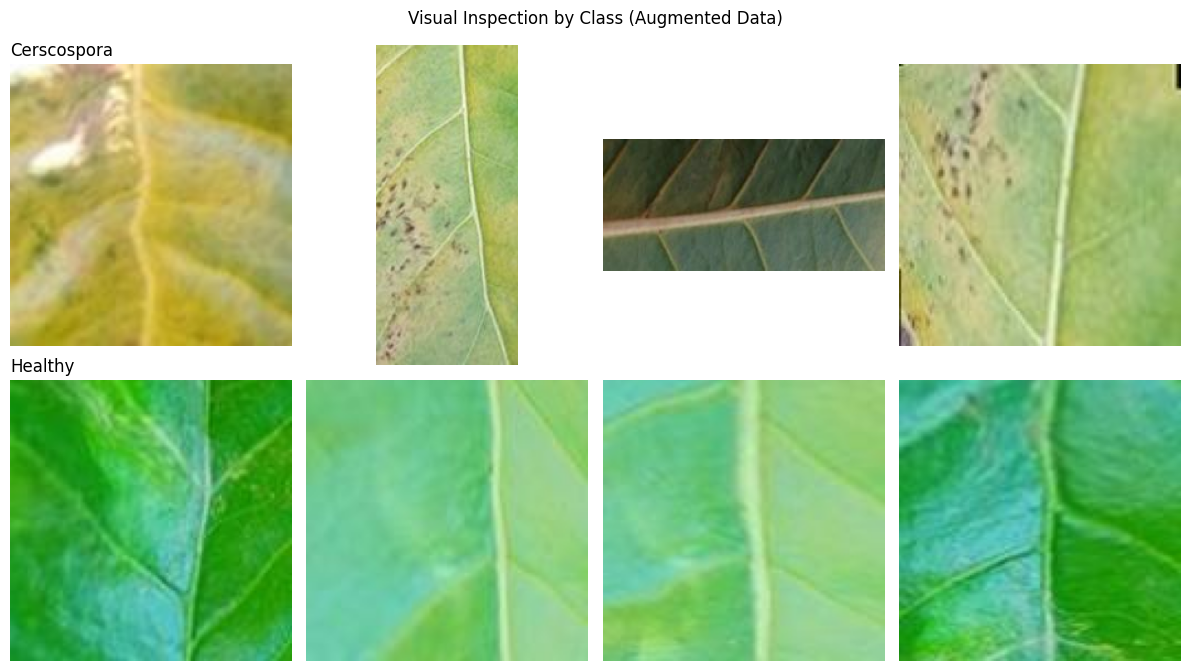

In [13]:
import random

random.seed(42)

classes = df[(df['Dataset']=='train')&(df['Count']<500)]
classes = classes['Class'].to_list()

num_samples_per_class = 4 
fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(12, (3*len(classes))+1))

for row, cls in enumerate(classes):
    cls_path = os.path.join(train_data_dir, cls, 'output')
    if os.path.exists(cls_path):
        sample_images = random.sample(os.listdir(cls_path), num_samples_per_class)

        for col, img_name in enumerate(sample_images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            ax = axes[row, col] if len(classes) > 1 else axes[col] 
            ax.imshow(img)
            ax.axis('off')

            if col == 0: 
                ax.set_title(cls, loc='left')

plt.suptitle('Visual Inspection by Class (Augmented Data)')
plt.tight_layout()
plt.show()

Have at least 100 samples for each class in test data

In [14]:
df_ = df[df['Dataset']=='test']
df_.set_index(keys=['Class'], inplace=True, drop=True)
df_

,Dataset,Count
Class,,
Cerscospora,test,65
Phoma,test,139
Healthy,test,13
Leaf rust,test,209
Miner,test,328


In [15]:
augment_probability = .75
test_data_dir = os.path.join(split_dataset_path, 'test')

for class_name in os.listdir(test_data_dir):
    class_count = df_.loc[class_name, 'Count']

    if class_count < 100:
        new_samples_count = 100-class_count
        print(f'Creating {new_samples_count} samples for {class_name}')

        p = Augmentor.Pipeline(os.path.join(test_data_dir, class_name))
        p.set_seed(42)
        
        p.zoom(probability=augment_probability, min_factor=1.1, max_factor=1.25)
        p.flip_random(probability=augment_probability)
        p.rotate(probability=augment_probability,
                        max_left_rotation=10, max_right_rotation=10)
        p.skew(probability=augment_probability, magnitude=.5)
        p.shear(probability=augment_probability,
                max_shear_left=10, max_shear_right=10)
        p.random_distortion(probability=augment_probability,
                                grid_height=5, grid_width=5, magnitude=5)
        
        time.sleep(.5)
        p.sample(new_samples_count-1)

Creating 35 samples for Cerscospora
Initialised with 65 image(s) found.
Output directory set to dataset_splitted/test/Cerscospora/output.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x3006696D0>: 100%|██████████| 34/34 [00:00<00:00, 383.05 Samples/s]


Creating 87 samples for Healthy
Initialised with 13 image(s) found.
Output directory set to dataset_splitted/test/Healthy/output.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x300941130>: 100%|██████████| 86/86 [00:00<00:00, 431.03 Samples/s]


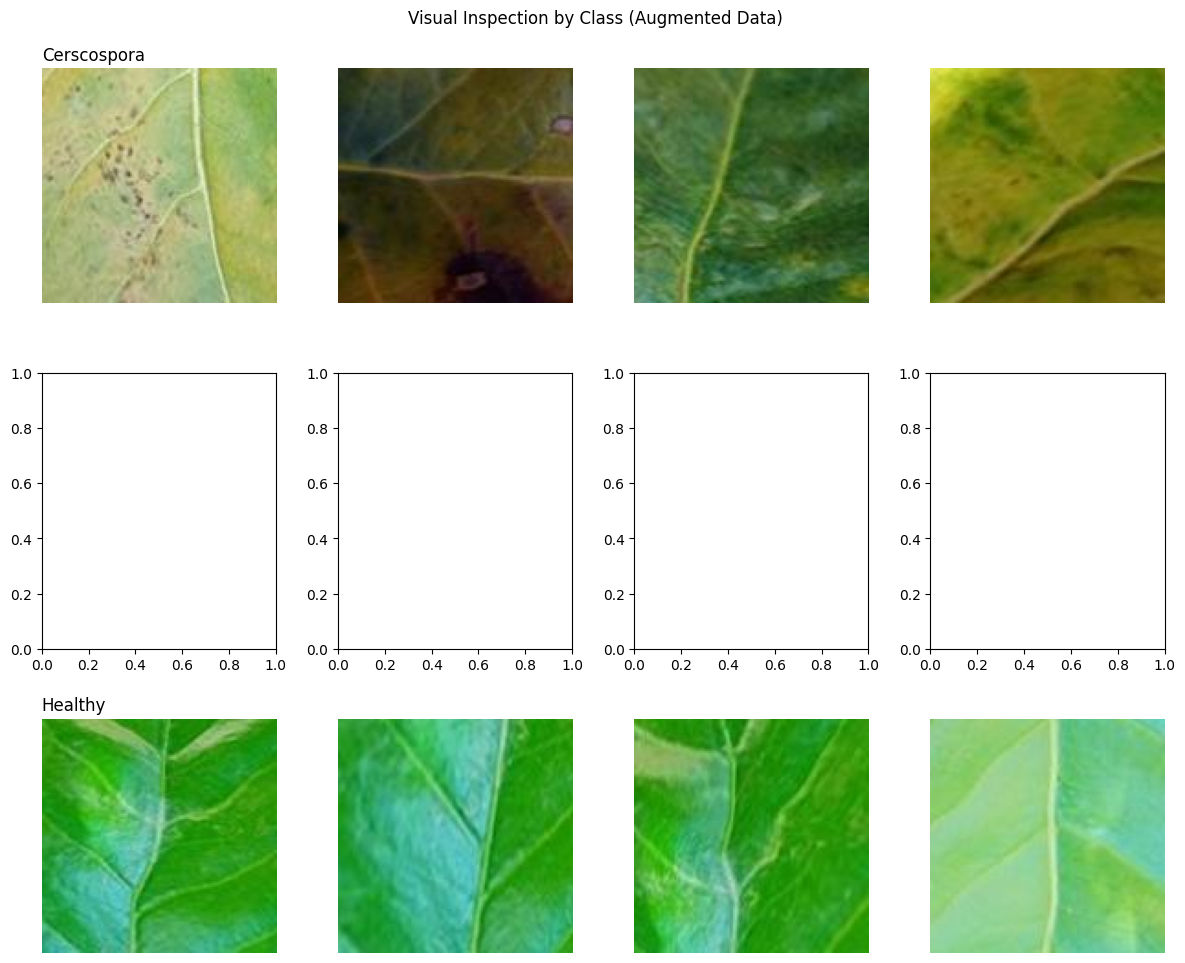

In [16]:
classes = df[(df['Dataset']=='test')&(df['Count']<150)]
classes = classes['Class'].to_list()

num_samples_per_class = 4 
fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(12, (3*len(classes))+1))

for row, cls in enumerate(classes):
    cls_path = os.path.join(test_data_dir, cls, 'output')
    if os.path.exists(cls_path):
        sample_images = random.sample(os.listdir(cls_path), num_samples_per_class)

        for col, img_name in enumerate(sample_images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            ax = axes[row, col] if len(classes) > 1 else axes[col] 
            ax.imshow(img)
            ax.axis('off')

            if col == 0: 
                ax.set_title(cls, loc='left')

plt.suptitle('Visual Inspection by Class (Augmented Data)')
plt.tight_layout()
plt.show()

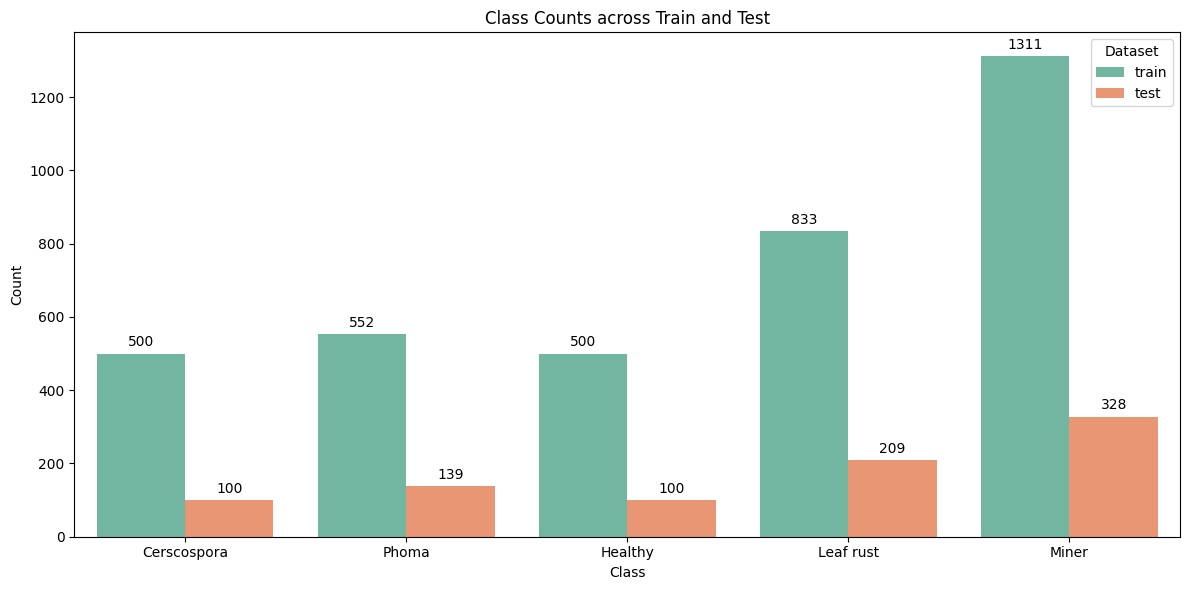

In [17]:
dataset_path = split_dataset_path

# Collect class counts for each dataset split
data = []

for split in ['train', 'test']:
    split_path = os.path.join(dataset_path, split)
    for cls in os.listdir(split_path):
        count = len(os.listdir(os.path.join(split_path, cls)))
        if os.path.exists(os.path.join(split_path, cls, 'output')):
            count += len(os.listdir(os.path.join(split_path, cls, 'output')))        
        data.append({'Dataset': split, 'Class': cls, 'Count': count})

# Convert to a DataFrame for easier plotting
df = pd.DataFrame(data)

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='Class', y='Count', hue='Dataset', palette='Set2')
ax.set_title('Class Counts across Train and Test')
plt.xlabel('Class')
plt.ylabel('Count')

# Annotate counts on the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%d', padding=3)

plt.tight_layout()
plt.show()